## Q5: Planetary orbits

We want to consider planetary orbits.  To do this, we need to solve Newton's second law together with Newton's law of gravity.  If we restrict ourselves to the x-y plane, then there are 4 quantities we need to solve for: $x$, $y$, $v_x$, and $v_y$.  These evolve according to:

\begin{align*}
\frac{dx}{dt} &= v_x \\
\frac{dy}{dt} &= v_y \\
\frac{dv_x}{dt} &= a_x = -\frac{GM_\star x}{r^3} \\
\frac{dv_y}{dt} &= a_y = -\frac{GM_\star y}{r^3}
\end{align*}

To integrate these forward in time, we need an initial condition for each quantity.  We'll setup our system such that the Sun is at the origin (that will be one focus), and the planet begins at perihelion and orbits counterclockwise. 

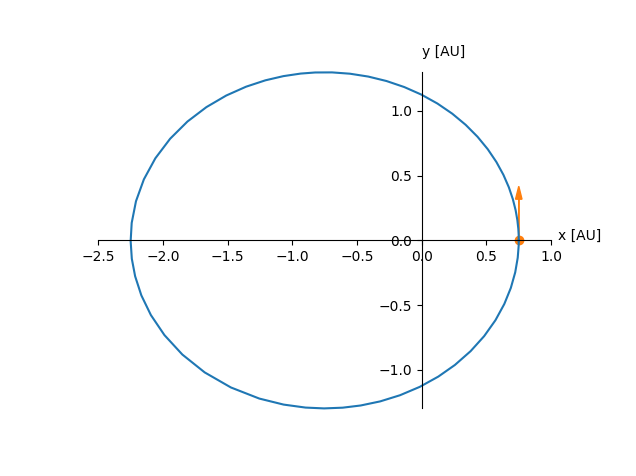

The distance of perihelion from the focus is:

$$r_p = a (1 - e)$$

where $a$ is the semi-major axis and $e$ is the eccentricity.  The perihelion velocity is all in the $y$ direction and is:

$$v_y = v_p = \sqrt{\frac{GM_\star}{a} \frac{1+e}{1-e}}$$

We'll work in units of AU, years, and solar masses, in which case, $GM_\star = 4\pi^2$ (for the Sun).  

Your initial conditions should be:

  * $x(t=0) = r_p$
  * $y(t=0) = 0$
  * $v_x(t=0) = 0$
  * $v_y(t=0) = v_p$

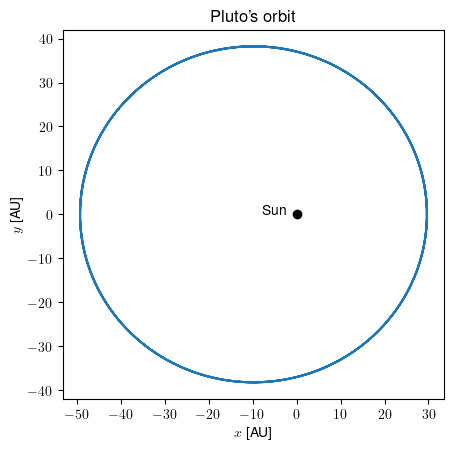

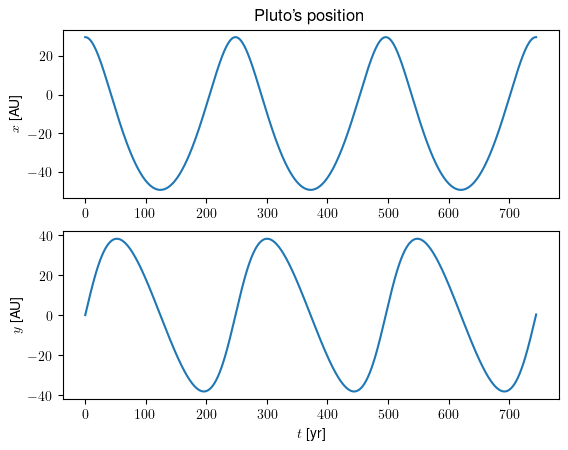

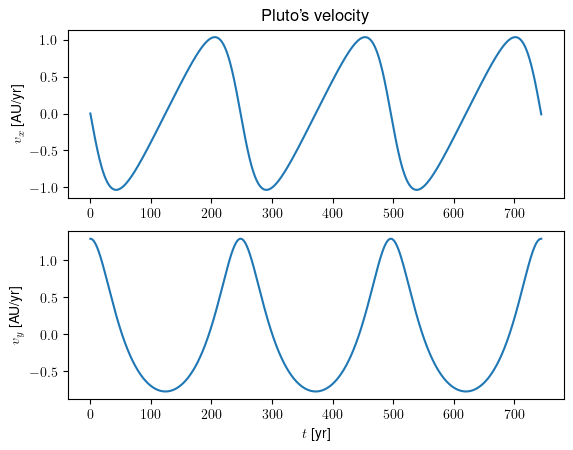

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})
from scipy import integrate

def rhs(t, x):
    r = np.sqrt(x[0]**2+x[1]**2)
    xdot = x[2]
    ydot = x[3]
    vxdot = -GM*x[0]/r**3
    vydot = -GM*x[1]/r**3

    return np.array([xdot, ydot, vxdot, vydot])

def jacob(t, x):
    r = np.sqrt(x[0]**2+x[1]**2)
    
    return np.array([ [0, 0, 1, 0], 
                      [0, 0, 0, 1],
                      [-GM*(x[1]**2-2*x[0]**2)/r**5, 0, 0, 0],
                      [0, -GM*(x[0]**2-2*x[1]**2)/r**5, 0, 0] ])

def ode_integrate(X0, dt, tmax):
    """ integrate using the VODE method, storing the solution each dt """

    r = integrate.solve_ivp(rhs, (0.0, tmax), X0,
                            method="LSODA", dense_output=True, jac=jacob, rtol=1e-10, atol=1e-10)
    
    # get the solution at intermediate times
    ts = np.arange(0.0, tmax+dt, dt)
    
    Xs = r.sol(ts)
    return ts, Xs

# Pluto's orbit (AU, M_sun, yr units)
GM = 4*np.pi**2
a = 39.482
e = 0.2488
P = np.sqrt(a**3)

# integration parameters
N_orbits = 3
N_steps = 1e3
total_time = N_orbits * P
time_step = P/N_steps

# we initialize the system at the pericenter
rp = a*(1-e)
vp = np.sqrt(GM*(1+e)/a/(1-e))

# run the integration
t, X = ode_integrate([rp,0,0,vp], time_step, total_time)

# plot the orbit
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
ax1.set_title(r"Pluto's orbit")
ax1.set_aspect("equal")
ax1.set_xlabel(r"$x$ [AU]")
ax1.set_ylabel(r"$y$ [AU]")

ax1.plot(X[0,:], X[1,:])
ax1.scatter(0,0,color="black")
ax1.text(-a/5,0,"Sun")

# plot x and y
fig2 = plt.figure()
ax21 = fig2.add_subplot(211)
ax21.set_title(r"Pluto's position")
ax21.set_ylabel(r"$x$ [AU]")
ax22 = fig2.add_subplot(212, sharex=ax21)
ax22.set_xlabel(r"$t$ [yr]")
ax22.set_ylabel(r"$y$ [AU]")

ax21.plot(t, X[0,:])
ax22.plot(t, X[1,:])

# plot vx and vy
fig2 = plt.figure()
ax31 = fig2.add_subplot(211)
ax31.set_title(r"Pluto's velocity")
ax31.set_ylabel(r"$v_x$ [AU/yr]")
ax32 = fig2.add_subplot(212, sharex=ax31)
ax32.set_xlabel(r"$t$ [yr]")
ax32.set_ylabel(r"$v_y$ [AU/yr]")

ax31.plot(t, X[2,:])
ax32.plot(t, X[3,:])

plt.show()

## Q7: Noisy signal
A convolution is defined as:  

  \begin{equation}                                                                           
    (f \star g)(t) \equiv \int_{-\infty}^{\infty} f(\tau) g(t - \tau) d\tau                   
  \end{equation}                                                                             

  It is easy to compute this with FFTs, via the _convolution theorem_,                                                                        
  \begin{equation}                                         
    \mathcal{F}\{f \star g\} = \mathcal{F}\{f\} \, \mathcal{F}\{g\}                                          
  \end{equation}                                         
  That is: the Fourier transform of the convolution of $f$ and $g$ is simply
  the product of the individual transforms of $f$ and $g$.  This allows us
  to compute the convolution via multiplication in Fourier space and then take
  the inverse transform, $\mathcal{F}^{-1}\{\}$, to recover the convolution in real space:
  
  \begin{equation}
  f \star g = \mathcal{F}^{-1}\{ \mathcal{F}\{f\} \, \mathcal{F}\{g\}\}
  \end{equation}
  
A common use of a convolution is to smooth noisy data, for example by convolving noisy data with a Gaussian.  We'll do that here.

Here's some noisy data we'll work with
```python
def fdata(x, L):
    A = L/10.0
    return 2*np.sin(2*np.pi*x/L) + x*(L-x)**2/L**3 * np.cos(x) + \
           5*x*(L-x)/L**2 + A/2 + 0.1*A*np.sin(13*np.pi*x/L)

N = 2048
L = 50.0
x = np.linspace(0, L, N, endpoint=False)
orig = fdata(x, L)
noisy = orig + 0.5*np.random.randn(N)
```
SciPy provides a convolution function `scipy.signal.convolve()` that can do the convolution for us directly.  To smooth the data, we want to use a Gaussian, which can be produced by `scipy.signal.gaussian()`.

Convolve the noisy data with a Gaussian and plot the result together with the original data `orig`.  You'll need to play with the width of the Gaussian to get a nice smoothing.  You also will need to normalize the Gaussian so that it sums to 1, otherwise, your convolved data will be shifted verfically from the original function.

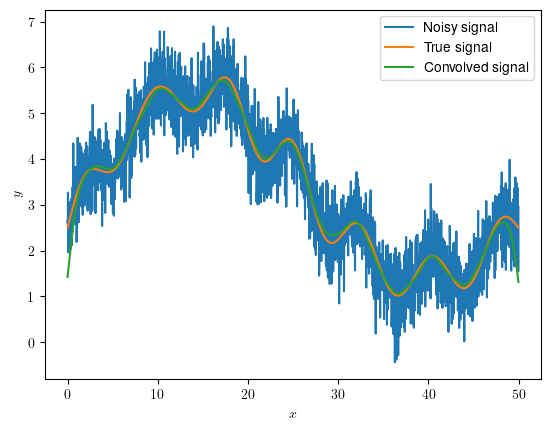

In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})
from scipy import signal

def fdata(x, L):
    A = L/10.0
    return 2*np.sin(2*np.pi*x/L) + x*(L-x)**2/L**3 * np.cos(x) + \
           5*x*(L-x)/L**2 + A/2 + 0.1*A*np.sin(13*np.pi*x/L)

N = 2048
L = 50.0
x = np.linspace(0, L, N, endpoint=False)
orig = fdata(x, L)
noisy = orig + 0.5*np.random.randn(N)

# build the normal distribution
width = N/75
norm = signal.windows.gaussian(N,width)
norm /= norm.sum()

# convolution
conv = signal.convolve(noisy, norm, mode="same")

# plot results
fig = plt.figure()
fig.tight_layout()
ax = fig.add_subplot(111)
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y$")

plt.plot(x, noisy, label="Noisy signal")
plt.plot(x, orig, label="True signal")
plt.plot(x, conv, label="Convolved signal")

plt.legend()
plt.show()